# Traffic Sign Classification with Tensorflow


## Step 0: Load Image Dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm
from zipfile import ZipFile

# Define variables
setnames = []
data     = dict()
X        = dict()
y        = dict()

path = "/home/tiwi/Documents/mldata/"
file = "traffic-signs-data.zip"


print("Filenames in data container: \n")
for filename in ZipFile(path+file).namelist():
    print(filename)
    # Create setnames from filenames: e.g. "train", "test", ...
    setnames.append(os.path.split(filename)[1].rpartition('.')[0])
    # Get full path + file for each pickle file
    with open(path + file.rpartition('.')[0] + '/' + filename, mode='rb') as f:
        data[setnames[-1]] = pickle.load(f)
        
for setname in setnames:
    X[setname], y[setname] = data[setname]['features'], data[setname]['labels']
        

Filenames in data container: 

test.p
train.p
valid.p



## Step 1: Print Dataset Information

In [2]:
classes = pd.read_csv("../CarND-Traffic-Sign-Classifier-Project/signnames.csv")
nb_classes = len(set(y["train"]))

print("Number of training examples:\t", X["train"].shape[0])
print("Number of testing examples:\t",  X["test"].shape[0])
print("Image data shape:\t\t",          X["train"].shape[1:])
print("Number of classes:\t\t",         nb_classes)

print(classes)

Number of training examples:	 34799
Number of testing examples:	 12630
Image data shape:		 (32, 32, 3)
Number of classes:		 43
    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Prior

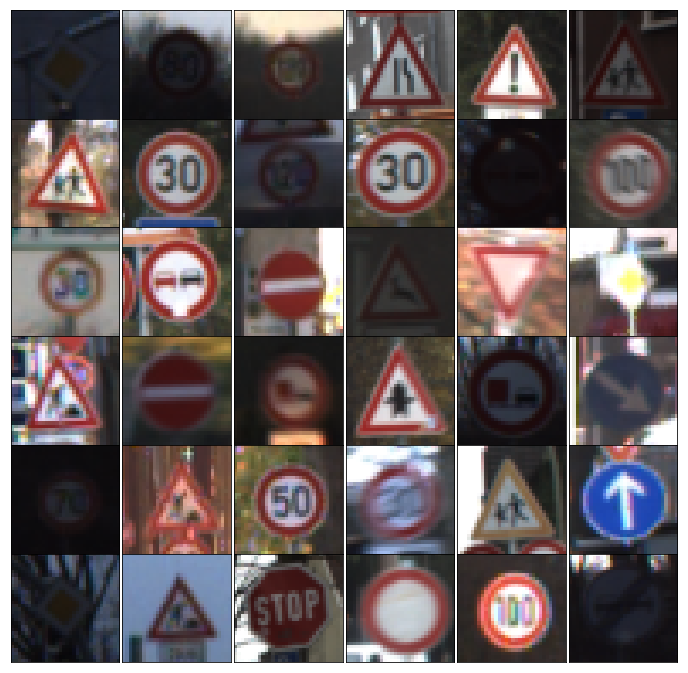

In [3]:
'''
Show all different interpolation methods for imshow
'''

import matplotlib.pyplot as plt
# Define square number of example images
n = np.int(np.floor(np.sqrt(nb_classes)))
nb_plots = n**2
random_images = [X["train"][i,::] for i in np.random.randint(0, X["train"].shape[0], nb_plots)]

# Setup a grid [n x n] grid of subplots
fig, axes = plt.subplots(n, n, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for img, ax, img_class in zip(random_images, axes.flat, classes["SignName"][0:nb_plots]):
    ax.imshow(img)
    
plt.show()



## Step 2: Design and Test a Model Architecture
The basic idea is to implement a simple CNN archictecture that gets a reasonable accurancy. But I want to try something new, therefore I'm going to reuse a pretrained model. I'll take ResNet50

### Preprocessing 1: Normalization

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder

print("Before Normalization")
print("Shape:\t", X["train"].shape)
print("Min:\t", X["train"].min())
print("Max:\t", X["train"].max())
print("Mean:\t", np.mean(X["train"]))

print("Shape y:", y["train"].shape)


def normalize(features, method='standard'):
    X = features.copy()
    if method=='standard':
        scaler = StandardScaler()
    elif method=='norm':
        scaler = Normalizer()
    elif method=='minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
        
    for key in X:
        shape      = X[key].shape
        image_size = shape[1] * shape[2] * shape[3]    
        X[key]     = X[key].reshape(-1, image_size)
        X[key]     = scaler.fit_transform(np.float32(X[key])).reshape(-1, shape[1], shape[2], shape[3])
    return X

def encode(labels):
    y = labels.copy()
    nb_classes = len(set(y["train"]))
    encoder = OneHotEncoder()

    for key in y:
        y[key] = encoder.fit_transform(y[key].reshape(-1, 1))
    return y

xx = normalize(X, method='minmax')
yy = encode(y)

print("\nAfter Normalization")
print("Shape:\t", xx["train"].shape)
print("Min:\t", xx["train"].min())
print("Max:\t", xx["train"].max())
print("Mean:\t", np.mean(xx["train"]))

print("Shape y:", yy["train"].shape)



Before Normalization
Shape:	 (34799, 32, 32, 3)
Min:	 0
Max:	 255
Mean:	 82.677589037
Shape y: (34799,)

After Normalization
Shape:	 (34799, 32, 32, 3)
Min:	 0.0
Max:	 1.0
Mean:	 0.313258
Shape y: (34799, 43)


In [5]:
print(xx["train"].shape)
print(xx["train"].min())
print(xx["train"].max())
print(np.mean(xx["train"]))



(34799, 32, 32, 3)
0.0
1.0
0.313258


### Model Architecture Design

In [29]:
from tensorflow.contrib.layers import flatten

def conv_relu_layer(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.get_variable("weights", kernel_shape, initializer=tf.random_normal_initializer())
    # Create variable named "biases".
    biases = tf.get_variable("biases", bias_shape, initializer=tf.constant_initializer(0.0))
    conv_ = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv_ + biases)

def dense_softmax_layer(input, output_shape, bias_shape):
    
    dense0 = flatten(input)
    weights_shape = [dense0.shape[1], output_shape]
    dense1_W = tf.get_variable("weights", weights_shape, initializer=tf.random_normal_initializer())
    dense1_b = tf.get_variable("biases", bias_shape, initializer=tf.constant_initializer(0.0))
    dense1_   = tf.matmul(dense0, dense1_W) + dense1_b 
    return tf.nn.softmax(dense1_)
    
def conv_relu_layer_1(input, kernel_shape, bias_shape):
    # Create variable named "weights".
    weights = tf.Variable(tf.truncated_normal(shape=kernel_shape), name="weights")
    # Create variable named "biases".
    biases = tf.Variable(tf.zeros(bias_shape), name="biases")
    conv_ = tf.nn.conv2d(input, weights, strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv_ + biases)




def create_model(input_images, params):
    """
    
    """
    nb_layers = len(params["nb_kernels"])
    
    kx   = params["kernel_size"][0][0]
    ky   = params["kernel_size"][0][1]
    nb_0 = input_images.shape[3]
    nb_1 = params["nb_kernels"][0]
    
    
    
    with tf.variable_scope("conv_layer_0", reuse=False):
        conv = conv_relu_layer(input_images, [kx, ky, nb_0, nb_1], [nb_1])
    
    for n in range(1, nb_layers):
        nb_0 = nb_1
        kx   = params["kernel_size"][n][0]
        ky   = params["kernel_size"][n][1]
        nb_1 = params["nb_kernels"][n]
    

        with tf.variable_scope("conv_layer_"+str(n), reuse=False):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            conv = conv_relu_layer(conv, [kx, ky, nb_0, nb_1], [nb_1])
            
    
    return conv


In [32]:
conv_params = dict({'kernel_size': [], 'nb_kernels':[]})
conv_params['kernel_size'] = [[3, 3],
                              [3, 1],
                              [1, 3],
                              [5, 5]]
conv_params['nb_kernels'] = [6,
                             6,
                             12,
                             32]    

input_images = tf.placeholder(dtype='float32', shape=(None, 32, 32, 3))
test_conv = conv_relu_layer_1(input_images, [3,3,3,3], [3])
test_model = create_model(input_images, params=conv_params)
test_dense = dense_softmax_layer(test_model, 10, 10)
for n in range(len(conv_params['kernel_size'])):
    print(conv_params['kernel_size'][n])
    print(conv_params['nb_kernels'][n])


ValueError: Variable conv_layer_0/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-9-c99b0a11c586>", line 3, in conv_relu_layer
    weights = tf.get_variable("weights", kernel_shape, initializer=tf.random_normal_initializer())
  File "<ipython-input-9-c99b0a11c586>", line 34, in create_model
    conv = conv_relu_layer(input_images, [kx, ky, nb_0, nb_1], [nb_1])
  File "<ipython-input-10-303477bde27d>", line 13, in <module>
    test_model = create_model(input_images, params=conv_params)


In [11]:
whos

Variable            Type              Data/Info
-----------------------------------------------
MinMaxScaler        type              <class 'sklearn.preprocessing.data.MinMaxScaler'>
Normalizer          type              <class 'sklearn.preprocessing.data.Normalizer'>
OneHotEncoder       type              <class 'sklearn.preproces<...>sing.data.OneHotEncoder'>
StandardScaler      type              <class 'sklearn.preproces<...>ing.data.StandardScaler'>
X                   dict              n=3
ZipFile             type              <class 'zipfile.ZipFile'>
ax                  AxesSubplot       Axes(0.7725,0.125;0.125833x0.125833)
axes                ndarray           6x6: 36 elems, type `object`, 288 bytes
classes             DataFrame             ClassId              <...>icles over 3.5 metric ...
conv_params         dict              n=2
conv_relu_layer     function          <function conv_relu_layer at 0x7f254accf730>
conv_relu_layer_1   function          <function conv_relu_layer_